In [1]:
import os
import shutil
import unittest
from mavi.trainer import LightningCountVAE
from mavi.sim import nb_alr_bioms, multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns

# Simulate data

In [2]:
np.random.seed(0)
sims = multinomial_bioms(k=4, D=10, N=500, M=100)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

# Train model

In [3]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'test.biom',
    '--val-biom', 'valid.biom',
    '--output-directory', output_dir,
    '--epochs', '1024',
    '--batch-size', '500',
    '--num-workers', '10',
    '--scheduler', 'cosine',
    '--reconstruction-loss', 'multinomial',
    '--learning-rate', '1e-2',
    '--n-latent', '4',
    '--n-samples', '10',
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCountVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCountVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=10,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | CountVAE | 155   


/home/juermieboop/miniconda3/envs/mavi/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [4]:
model.gt_eigvectors

array([[ 0.4585559 ,  0.35990241,  0.48965761, -0.12569674],
       [ 0.10401871, -0.03626017, -0.04343   , -0.30272333],
       [ 0.25441767, -0.56244143, -0.1726481 ,  0.18455065],
       [ 0.58250812, -0.18344912, -0.46206716, -0.00335897],
       [ 0.48546164,  0.06747852,  0.3213016 ,  0.39226445],
       [-0.25403812, -0.25350974,  0.11513235,  0.38063807],
       [ 0.24697037, -0.08251232, -0.11182901,  0.04716735],
       [-0.03934449, -0.65204116,  0.50260214, -0.22742602],
       [-0.02683118,  0.08158075, -0.36337729, -0.14952816],
       [ 0.10673287, -0.10825711,  0.03725543, -0.69528838]])

In [5]:
!ls

lightning_logs	train.biom	 vae-finetune.ipynb  valid.biom
test.biom	train-vae.ipynb  vae-sim.ipynb


In [6]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 32924), started 1 day, 3:03:56 ago. (Use '!kill 32924' to kill it.)

In [8]:
trainer.model

LightningCountVAE(
  (model): CountVAE(
    (encoder): Encoder(
      (encoder): FCLayers(
        (fc_layers): Sequential(
          (Layer 0): Sequential(
            (0): Linear(in_features=10, out_features=4, bias=False)
            (1): None
            (2): None
            (3): None
          )
        )
      )
    )
    (decoder): LinearDecoder(
      (factor_regressor): FCLayers(
        (fc_layers): Sequential(
          (Layer 0): Sequential(
            (0): Linear(in_features=4, out_features=10, bias=True)
            (1): None
            (2): None
            (3): None
          )
        )
      )
      (px_eta_decoder): FCLayers(
        (fc_layers): Sequential(
          (Layer 0): Sequential(
            (0): Linear(in_features=4, out_features=10, bias=True)
            (1): None
            (2): None
            (3): None
          )
        )
      )
    )
  )
)

# Evaluate the model

In [13]:
!ls lightning_logs/version_0/checkpoints

'epoch=399.ckpt'


In [14]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_0/checkpoints'
path = f'{checkpoint_dir}/epoch=399.ckpt'
model = LightningCountVAE.load_from_checkpoint(path).cuda()

In [15]:
valid

11 x 50 <class 'biom.table.Table'> with 521 nonzero entries (94% dense)

In [16]:
import torch
from mavi.dataset.biom import BiomDataset
from skbio.stats.composition import alr_inv, closure
valid_dataset = BiomDataset(valid)

In [17]:
z = [] 
pred_z = []
pred_probs = []
counts = []
for i in range(len(valid_dataset)):
    cnts, batch_idx = valid_dataset[i]
    counts.append(closure(cnts))
    cnts = torch.Tensor(cnts).cuda().unsqueeze(0)
    smoothed_cnts = cnts + 1
    res = model.model.inference(smoothed_cnts)
    z.append(sims['z'][parts * 8 + i])
    pred_z.append(res['qz_m'].cpu().detach().numpy())
    pred_probs.append(alr_inv(res['px_mean'].cpu().detach().numpy()))

In [18]:
counts = np.vstack(counts)
pred_probs = np.vstack(pred_probs)
pred_z = np.vstack(pred_z)

In [19]:
from scipy.spatial.distance import pdist
d_predz = pdist(pred_z)
dz = pdist(z)

In [20]:
z = np.vstack(z)

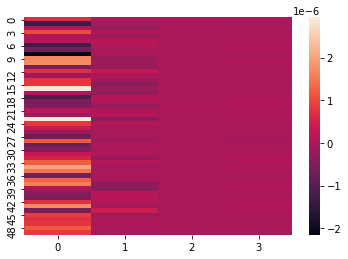

In [21]:
sns.heatmap(pred_z)

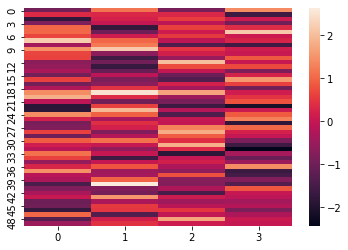

In [22]:
sns.heatmap(z)

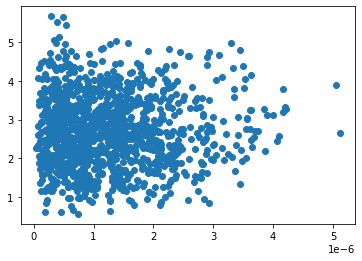

In [23]:
import matplotlib.pyplot as plt
plt.scatter(d_predz, dz)

In [24]:
from scipy.stats import pearsonr
pearsonr(d_predz, dz)

(0.025168011608311936, 0.37879401575745114)

(0.5804976779510325, 2.9134770977775727e-05)


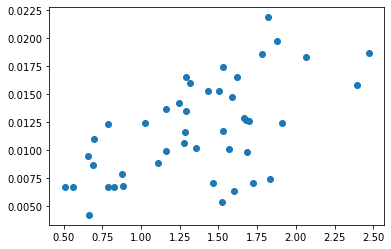

In [27]:
W = model.model.get_loadings()
d_estW = pdist(W)
dW = pdist(sims['W'])
plt.scatter(dW, d_estW)
print(pearsonr(dW, d_estW))

(0.0037266097518011097, 0.9337551276202384)


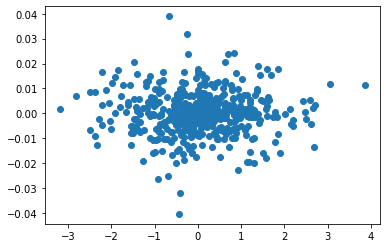

In [31]:
lam = np.ravel(sims['z'][parts * 8 : parts * 8 + 50] @ sims['W'].T)
pred_lam = np.ravel(z @ W.T)
plt.scatter(lam, pred_lam)
print(pearsonr(lam, pred_lam))

In [32]:
z.shape, W.shape, lam.shape, sims['z'].shape, sims['W'].shape

((50, 4), (10, 4), (500,), (500, 4), (10, 4))

In [33]:
from scipy.stats import entropy
ens = []
for i in range(counts.shape[0]):
    e = entropy(counts[i], pred_probs[i])
    ens.append(e)

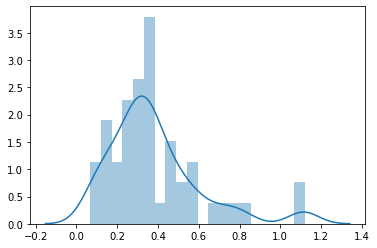

In [34]:
sns.distplot(ens, bins=20)

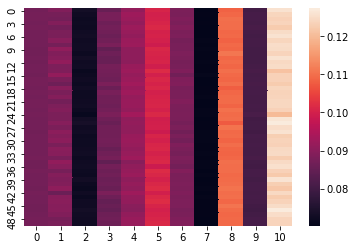

In [35]:
sns.heatmap(pred_probs)

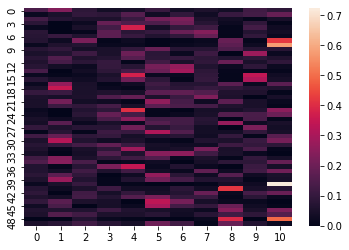

In [36]:
sns.heatmap(counts)

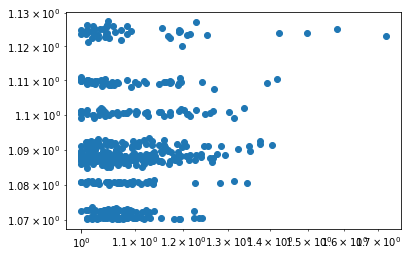

In [37]:
plt.scatter(counts.ravel()+1, pred_probs.ravel()+1)
plt.xscale('log')
plt.yscale('log')

In [38]:
pearsonr(counts.ravel()+1, pred_probs.ravel()+1)

(0.12301753871156944, 0.0038593443346187878)

In [40]:
torch.exp(model.model.encoder.variational_logvars)

tensor([1., 1., 1., 1.], device='cuda:0', grad_fn=<ExpBackward>)

In [ ]:
parser